### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import nevergrad as ng
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load, standardize and split data
- data set comprises operational data of a single wind energy system:
  - 184702 rows
  - columns "wind_speed", "temperature" and "power"(target)
  - dataset represents higher wind speeds (>10 m/s) poorly
- input data standardized to mean=0, std=1
- train/validation/split = 0,7 / 0,15 / 0,15

In [4]:
os.chdir("C:/Users/Paul.Wecker/PyDataScience/Suspicious Wind Power/ANN_power_curve/data/")
df = pd.read_parquet("dataframe_263")
df = df.loc[~df["temperature"].isna()]

features = ["wind_speed", "temperature"]
target = "power"

wind_speed_mean = df["wind_speed"].mean()
wind_speed_std = df["wind_speed"].std()
temperature_mean = df["temperature"].mean()
temperature_std = df["temperature"].std()

x = df[features].values
y = df[target].values

scaler = StandardScaler()
x = scaler.fit_transform(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=(1 - train_ratio), random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_ratio / (test_ratio + val_ratio),
                                                random_state=42)

input_dim = x_train.shape[1]

### Define Network
The architecture is a 12 x 24 x 12 MLP using batch normalization, Relus and one sigmoid activation function which resembles typical power curve provided by energy system manufacturers:
- batch norm
- layer of 4, relu
- layer of 12, relu
- layer of 24, sigmoid
- layer of 12
- output

In [5]:
class PowerPredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(PowerPredictionModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 12)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(12, 24)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(24, 12)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(12, 12)
        self.sig = nn.Sigmoid()
        self.fc5 = nn.Linear(12, 1)  # Output layer with 1 neuron (regression)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sig(x)
        x = self.fc4(x)
        x = self.sig(x)
        x = self.fc5(x)
        return x

### Create training functions
Two functions were defined:
- "create_train_model" is dedicated to being used with nevergrad to find a good learning rate.
- "train_final_model" is called once to train the model with the learning rate recommended by nevergrad.
- by default, both use a batch size of 1000 and 100 epochs


In [6]:
def train_final_model(input_dim,
                x_train, y_train,
                x_val, y_val,
                learn_rate=.0333, num_epochs=100, batch_size=1000):

    model = PowerPredictionModel(input_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses, val_losses = [], []
    
    

    for epoch in range(num_epochs):
        old_train_losses, old_val_losses, old_model = train_losses, val_losses, model
        model.train()
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size][:, None]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            val_output = model(x_val)
            val_loss = criterion(val_output, y_val[:, None])

        # Collect losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {loss.item():.1f} | Val Loss: {val_loss.item():.1f}")
        
        # Stopping criterion: stop if no improvement from last and third last
        if len(val_losses) > 5:
            if (val_losses[-2] < val_losses[-1]) and (val_losses[-4] < val_losses[-1]):
                print(f"*** Decrease of validation performance after {epoch + 1} epochs.")
                print(f"Returning old model from epoch {epoch}.")
                return old_train_losses, old_val_losses, old_model, epoch + 1

    return train_losses, val_losses, model, epoch + 1


def create_train_model(input_dim=input_dim,
                       x_train=x_train, y_train=y_train,
                       x_val=x_val, y_val=y_val,
                       learn_rate=0.0333, num_epochs=100, batch_size=1000):
    print(f"*** Current learning rate: {learn_rate}")
    model = PowerPredictionModel(input_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size][:, None]

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            val_output = model(x_val)
            val_loss = criterion(val_output, y_val[:, None])
            
    # only return validation loss for HPO with nevergrad
    return float(val_loss)

### Use Nevergrad to find suitable learning rate
The package [nevergrad](https://github.com/facebookresearch/nevergrad) is experimented with to find a good candidate for the learning rate hyperparameter. It tests budget=50 learning rates from a given logarithmic scale.

In [7]:
# set logarithmic search space for learning rate search
instrumentation = ng.p.Instrumentation(learn_rate=ng.p.Log(lower=0.0001, upper=.1))
optimizer = ng.optimizers.NGOpt(parametrization=instrumentation,
                                budget=20) # try out 20 learning rates

# start search & retrieve recommendation
recommender = optimizer.minimize(create_train_model)
recommended_learning_rate = recommender.value[1]['learn_rate']
print(f"Recommended value for learning rate: f{recommended_learning_rate}")

*** Current learning rate: 0.0031622776601683772
*** Current learning rate: 0.009999999999999993
*** Current learning rate: 0.03162277660168377
*** Current learning rate: 0.09999999999999991
*** Current learning rate: 0.05623413251903486
*** Current learning rate: 0.023713737056616533
*** Current learning rate: 0.03651741272548374
*** Current learning rate: 0.029427271762092796
*** Current learning rate: 0.03278121151393456
*** Current learning rate: 0.031059002236247024
*** Current learning rate: 0.03190848980629105
*** Current learning rate: 0.03148088080484501
*** Current learning rate: 0.03141017185010455
*** Current learning rate: 0.031339621714182135
*** Current learning rate: 0.03126923004035608
*** Current learning rate: 0.03130440609177085
*** Current learning rate: 0.03135724437842047
*** Current learning rate: 0.031330814096364824
*** Current learning rate: 0.03134402645153575
*** Current learning rate: 0.03133741957763288
Recommended value for learning rate: f0.031339621714

### Train model on recommended learning rate & plot results

Epoch [10/150] | Train Loss: 149232.1 | Val Loss: 154782.0
Epoch [20/150] | Train Loss: 72363.3 | Val Loss: 70148.6
Epoch [30/150] | Train Loss: 37654.0 | Val Loss: 33412.1
Epoch [40/150] | Train Loss: 20168.9 | Val Loss: 16757.9
Epoch [50/150] | Train Loss: 10743.2 | Val Loss: 9159.0
Epoch [60/150] | Train Loss: 6130.9 | Val Loss: 5544.5
Epoch [70/150] | Train Loss: 3877.4 | Val Loss: 3910.0
*** Decrease of validation performance after 74 epochs.
Returning old model from epoch 73.


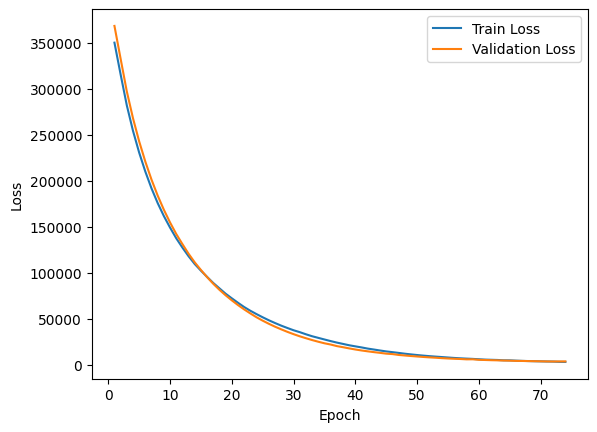

In [10]:
num_epochs = 150
train_losses, val_losses, model, num_epochs = train_final_model(input_dim, x_train, y_train, x_val, y_val, num_epochs=num_epochs,
                                                                learn_rate=recommended_learning_rate)

plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Use test set for plotting & error estimation
Compute the test outcomes & the test error. Also, the test set is "unstandardized" in order to plot predictions.

Test Loss: 3781.5


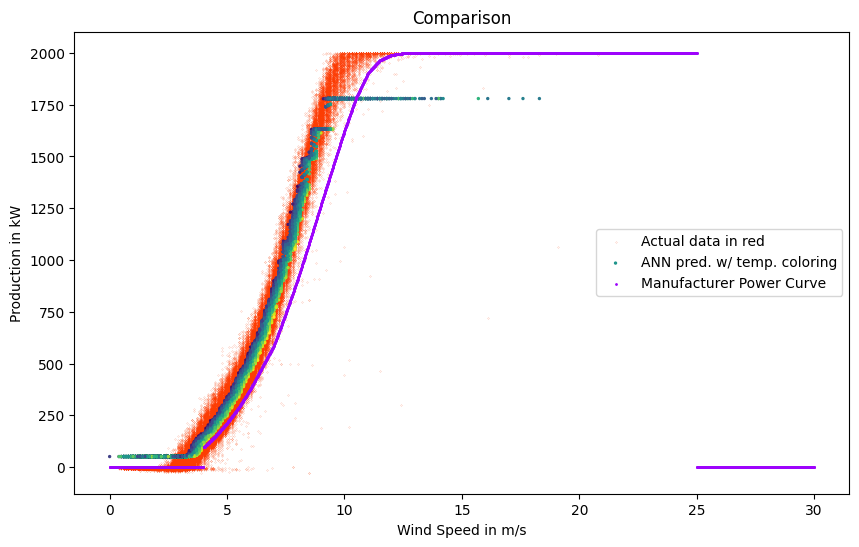

In [19]:
model.eval()
with torch.no_grad():
    test_output = model(x_test)
    criterion = nn.MSELoss()
    test_loss = criterion(test_output, y_test[:, None])

print(f"Test Loss: {test_loss.item():.1f}")

test_unstandardized = x_test.T
wind_speed_test = test_unstandardized[0] * wind_speed_std + wind_speed_mean
temp_test = test_unstandardized[1] * temperature_std + temperature_mean
plt.figure(figsize=(10,6))
plt.scatter(x=df["wind_speed"], y=df["power"], s=.01, color="#fc3d03", label="Actual data in red")

plt.scatter(x=wind_speed_test, y=test_output, c=temp_test, s=2,
            label="ANN pred. w/ temp. coloring")
mpc = pd.read_parquet("power_curve_263") # mpv for manufacturer power curve
plt.scatter(x=mpc.index,
            y=mpc["power"],
            s=1,
            c="#9d03fc",
            label="Manufacturer Power Curve")
plt.xlabel("Wind Speed in m/s")
plt.ylabel("Production in kW")
plt.legend(loc="center right")
plt.title("Comparison")
plt.show()

## Compute the error of the manufacturer power curve


In [13]:
manufacuter_predictions = np.array([mpc.loc[round(float(wind_speed), 2)]["power"]
                                    for wind_speed in wind_speed_test])

true_power_production = np.array(test_output).flatten()

mse_manufacturer = sum((true_power_production - manufacuter_predictions)**2)/len(manufacuter_predictions)

print(f"Test Loss Neural Network MSE: {test_loss}")
print(f"Manufacturer Prediction MSE:  {mse_manufacturer}")

Test Loss Neural Network MSE: 3781.520751953125
Manufacturer Prediction MSE:  26595.038436376733


## Outlook:
- implement robust solution to abandon manufacturer power curves!
- use nevergrad for further optimization (maybe even for architecture)
- use model on data of other systems of similar type
- train model for all systems of same type
- experiment with transfer learning
- look into time series architectures to make use out of time (although 10 minutes are probably too long!)

## Some code for the pptx images:
- Histogram wind speed
- Histogram temperature
- statistics dataset

In [ ]:
plt.hist(bins=50, x=df["wind_speed"])
plt.xlabel("Windspeed in m/s")
plt.ylabel("count")
plt.show()

In [ ]:
plt.hist(x=df["temperature"], bins=25)
plt.xlabel("Temperature in °C")
plt.ylabel("count")
plt.show()

In [ ]:
print(f"Dataset with size: {len(df)}")
print(f"Mean of windspeed: {round(df['wind_speed'].mean(), 2)} m/s")
print(f"Std of windspeed: {round(df['wind_speed'].std(), 2)}")
print(f"Mean of temperature: {round(df['temperature'].mean(), 2)} °C")
print(f"Std of temperature: {round(df['temperature'].std(), 2)}")
print(f"Mean of output power: {round(df['power'].mean(), 2)} in kW")
print(f"Std of output power: {round(df['power'].std(), 2)}")

In [ ]:
df[["power", "wind_speed", "temperature"]].head(4)

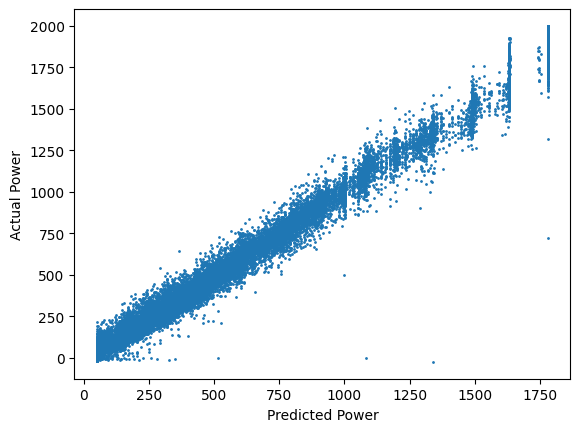

In [15]:
plt.scatter(x=test_output, y=y_test, s=1)
plt.xlabel("Predicted Power")
plt.ylabel("Actual Power")
plt.show()

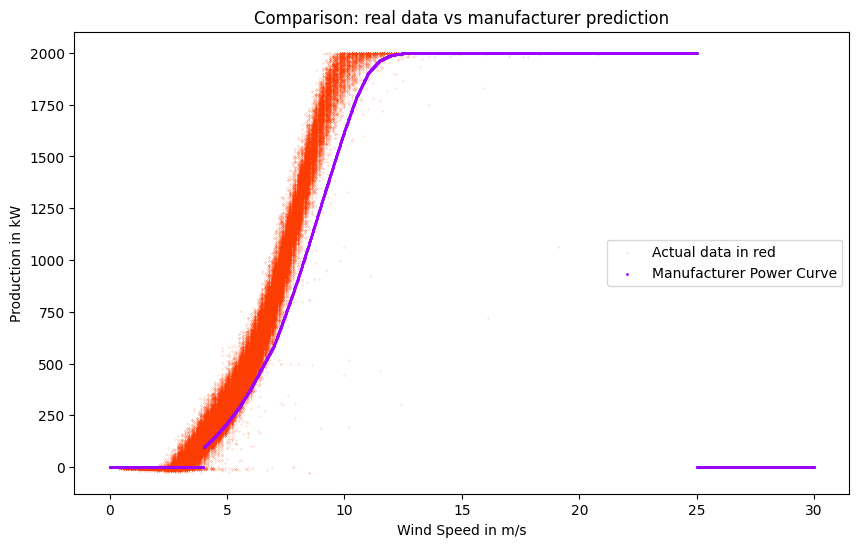

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(x=df["wind_speed"], y=df["power"], s=.01, color="#fc3d03", label="Actual data in red")

plt.scatter(x=mpc.index,
            y=mpc["power"],
            s=1,
            c="#9d03fc",
            label="Manufacturer Power Curve")
plt.xlabel("Wind Speed in m/s")
plt.ylabel("Production in kW")
plt.legend(loc="center right")
plt.title("Comparison: real data vs manufacturer prediction")
plt.show()